In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,533 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [90.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic I

In [ ]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [ ]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [ ]:
tf.version.VERSION

'2.9.1'

In [ ]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [ ]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

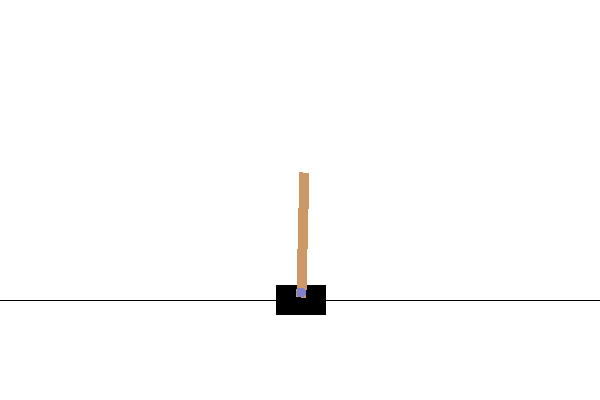

In [ ]:
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

In [ ]:

print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [ ]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [ ]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [ ]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.0034714 , -0.01553698,  0.00350844, -0.03062587], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.00378214,  0.1795345 ,  0.00289592, -0.3221998 ], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [ ]:

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [ ]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [ ]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [ ]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))

In [ ]:
time_step = example_environment.reset()

In [ ]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

In [ ]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [ ]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

18.8

In [ ]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

In [ ]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [ ]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [ ]:
#@test {"skip": true}
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([-0.05042205, -0.04187205, -0.00393794, -0.02166793], dtype=float32),
  'reward': array(1., dtype=float32),
  'step_type': array(1, dtype=int32)}), ())

In [ ]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [ ]:
iterator = iter(dataset)
print(iterator)

In [ ]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 52.587039947509766
step = 400: loss = 5.857670783996582
step = 600: loss = 15.97494125366211
step = 800: loss = 11.986127853393555
step = 1000: loss = 14.313813209533691
step = 1000: Average Return = 47.599998474121094
step = 1200: loss = 19.77214813232422
step = 1400: loss = 155.13821411132812
step = 1600: loss = 23.551212310791016
step = 1800: loss = 514.77734375
step = 2000: loss = 60.23005676269531
step = 2000: Average Return = 93.5999984741211
step = 2200: loss = 204.23097229003906
step = 2400: loss = 32.1274299621582
step = 2600: loss = 17.705032348632812
step = 2800: loss = 35.67481231689453
step = 3000: loss = 74.47189331054688
step = 3000: Average Return = 155.5
step = 3200: loss = 11.142069816589355
step = 3400: loss = 18.068222045898438
step = 3600: loss = 25.629581451416016
step = 3800: loss = 110.0626220703125
step = 4000: loss = 255.35922241210938
step = 4000: Average Return = 180.3000030517578
step = 4200: loss = 191.53770446777344
step = 4400: loss = 

(9.739999198913575, 250.0)

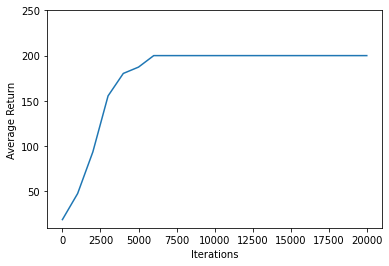

In [ ]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

In [ ]:
create_policy_eval_video(random_policy, "random-agent")

In [ ]:
# @title Install necessary packages.
!pip install -U dopamine-rl


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 4.7 MB/s 
     |████████████████████████████████| 352 kB 36.9 MB/s 
     |████████████████████████████████| 202 kB 41.6 MB/s 
     |████████████████████████████████| 596 kB 36.1 MB/s 
     |████████████████████████████████| 7.5 MB 38.2 MB/s 
     |████████████████████████████████| 217 kB 23.7 MB/s 
     |████████████████████████████████| 145 kB 43.5 MB/s 
     |████████████████████████████████| 51 kB 6.7 MB/s 
     |████████████████████████████████| 76 kB 5.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: dopamine-rl
    Found existing installation: dopamine-rl 1.0.5
    Uninstalling dopamine-rl-1.0.5:
      Successfully uninstalled dopamine-rl-1.0.5


In [ ]:
# @title Necessary imports and globals.

import numpy as np
import os
from dopamine.discrete_domains import run_experiment
from dopamine.colab import utils as colab_utils
from absl import flags
import gin.tf

BASE_PATH = '/tmp/colab_dopamine_run'  # @param

In [ ]:
# @title Load the configuration for DQN.

DQN_PATH = os.path.join(BASE_PATH, 'dqn')
# Modified from dopamine/agents/dqn/config/dqn_cartpole.gin
dqn_config = """
# Hyperparameters for a simple DQN-style Cartpole agent. The hyperparameters
# chosen achieve reasonable performance.
import dopamine.discrete_domains.gym_lib
import dopamine.discrete_domains.run_experiment
import dopamine.agents.dqn.dqn_agent
import dopamine.replay_memory.circular_replay_buffer
import gin.tf.external_configurables

DQNAgent.observation_shape = %gym_lib.CARTPOLE_OBSERVATION_SHAPE
DQNAgent.observation_dtype = %gym_lib.CARTPOLE_OBSERVATION_DTYPE
DQNAgent.stack_size = %gym_lib.CARTPOLE_STACK_SIZE
DQNAgent.network = @gym_lib.CartpoleDQNNetwork
DQNAgent.gamma = 0.99
DQNAgent.update_horizon = 1
DQNAgent.min_replay_history = 500
DQNAgent.update_period = 4
DQNAgent.target_update_period = 100
DQNAgent.epsilon_fn = @dqn_agent.identity_epsilon
DQNAgent.tf_device = '/gpu:0'  # use '/cpu:*' for non-GPU version
DQNAgent.optimizer = @tf.train.AdamOptimizer()

tf.train.AdamOptimizer.learning_rate = 0.001
tf.train.AdamOptimizer.epsilon = 0.0003125

create_gym_environment.environment_name = 'CartPole'
create_gym_environment.version = 'v0'
create_agent.agent_name = 'dqn'
TrainRunner.create_environment_fn = @gym_lib.create_gym_environment
Runner.num_iterations = 50
Runner.training_steps = 1000
Runner.evaluation_steps = 1000
Runner.max_steps_per_episode = 200  # Default max episode length.

WrappedReplayBuffer.replay_capacity = 50000
WrappedReplayBuffer.batch_size = 128
"""
gin.parse_config(dqn_config, skip_unknown=False)

([],
 ['dopamine.discrete_domains.gym_lib',
  'dopamine.discrete_domains.run_experiment',
  'dopamine.agents.dqn.dqn_agent',
  'dopamine.replay_memory.circular_replay_buffer',
  'gin.tf.external_configurables'])

In [ ]:
# @title Train DQN on Cartpole
dqn_runner = run_experiment.create_runner(DQN_PATH, schedule='continuous_train')
print('Will train DQN agent, please be patient, may be a while...')
dqn_runner.run_experiment()
print('Done training!')

Instructions for updating:
non-resource variables are not supported in the long term


Will train DQN agent, please be patient, may be a while...


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Done training!


In [ ]:
# @title Load the training logs.
data = colab_utils.read_experiment(DQN_PATH, verbose=True,
                                   summary_keys=['train_episode_returns'])
data['agent'] = 'DQN'
data['run'] = 1
c51_data = colab_utils.read_experiment(C51_PATH, verbose=True,
                                       summary_keys=['train_episode_returns'])
c51_data['agent'] = 'C51'
c51_data['run'] = 1
data = data.merge(c51_data, how='outer')